In [1]:
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.feature_extraction import DictVectorizer
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
import pickle

In [2]:
pd.__version__

'2.2.2'

In [3]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [18]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
x_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

reg = xgb.XGBRegressor(objective='reg:squarederror', learning_rate=0.8, n_estimators=500, verbosity=2)
reg.fit(x_train, y_train)

y_pred = reg.predict(x_train)

root_mean_squared_error(y_train, y_pred)

np.float64(3.4804001897516237)

/tmp/ipykernel_3913/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_3913/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


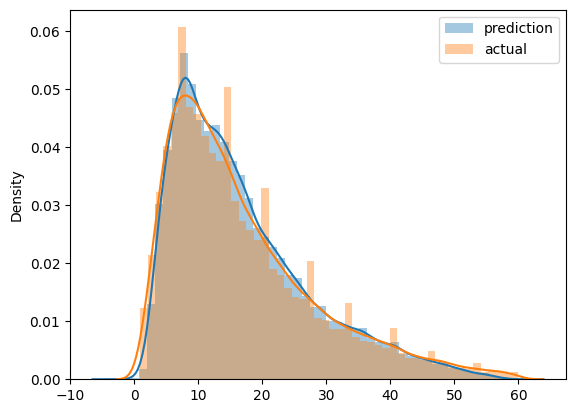

In [19]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [3]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [18]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [19]:
len(df_train), len(df_val)

(73908, 61921)

In [20]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [21]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [22]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [23]:
reg = xgb.XGBRegressor(objective='reg:squarederror', learning_rate=0.8, n_estimators=500, verbosity=2)
reg.fit(X_train, y_train)

y_pred = reg.predict(X_val)

root_mean_squared_error(y_val, y_pred)

np.float64(6.429234961685116)

In [24]:
with open('models/xgb_reg.bin', 'wb') as f_out:
    pickle.dump((dv, reg), f_out)